In [31]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

In [32]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')   # Check wether gpu is available

### The Mandelbrot set
The Mandelbrot set is a two-dimensional set that is defined in the complex plane as the complex numbers $c$ for which the function $f_c(z) = z^2 + c $ does not diverge to infinity when iterated starting at $z=0$.

Interesting properties:
- A point c belongs to the Mandelbrot set iff $|z| \leq 2$ for all $n \geq 0$


### Creating a dataset

In [33]:
def mandelbrot_grid_dataset(nx=750, ny=750, xlim=(-2.0, 1.0), ylim =(-1.5, 1.5), max_iter=1000):
    xs = np.linspace(xlim[0], xlim[1], nx)
    ys = np.linspace(ylim[0], ylim[1], ny)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    
    C = X + 1j * Y
    Z = np.zeros_like(C)
    mask = np.ones(C.shape, dtype=bool)

    for _ in range(max_iter):
        Z[mask] = Z[mask] * Z[mask] + C[mask]
        # Update mask for those that remain within radius 2
        mask[mask] = (np.abs(Z[mask]) <= 2.0)

    # If after max_iter still True, it's considered inside the set
    in_set = mask
    return X, Y, in_set

### Neural Network

In [34]:
class NeuralNet(nn.Module):
    def __init__(self, num_hidden_layers=3):
        super().__init__()
        
        layers = [
            nn.Linear(2, 32),
            nn.ReLU(),
        ]

        for _ in range(num_hidden_layers):
            layers.append(
                nn.Linear(32, 32)
            )
            layers.append(
                nn.ReLU()
            )
        
        # Output
        layers.append(
            nn.Linear(32, 1)
        )
        self.sigmoid_layer = nn.Sigmoid()
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.network(x)
        # return self.sigmoid_layer(x)
        return x

### Visualization Function

In [35]:
@torch.no_grad()
def plot_decision_boundary(model, epoch, real_res=400, imag_res=400, xlim=(-2, 1), ylim=(-1.5, 1.5), outdir="images"):
    """
    Generates and saves an image of the model's decision boundary.
    """
    xs = np.linspace(xlim[0], xlim[1], real_res)
    ys = np.linspace(ylim[0], ylim[1], imag_res)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    grid_tensor = torch.from_numpy(grid).float().to(device)

    # Set the model to evaluation mode
    model.eval()
    logits = model(grid_tensor).squeeze(1)
    probs = torch.sigmoid(logits).cpu().numpy().reshape(imag_res, real_res)  # (H, W)

    plt.figure(figsize=(6, 6))
    plt.imshow(
        probs,
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        origin="lower",
        cmap="hot",
        aspect="auto",
    )
    plt.title(f"Decision Boundary @ epoch {epoch+1}")
    plt.xlabel("Real")
    plt.ylabel("Imag")
    os.makedirs(outdir, exist_ok=True)
    fname = f"{outdir}/mandelbrot_epoch_{epoch+1}.png"
    plt.savefig(fname, dpi=160, bbox_inches="tight")
    plt.close()
    print(f"Saved image: {fname}")

### Training Loop

In [36]:
from torch.utils.data import TensorDataset, DataLoader

def train(model, X_train, y_train, X_val, y_val, num_epoch=20, batch_size=16, lr=0.0001, criterion=nn.BCEWithLogitsLoss(), visualize=False):
    # Load model into GPU
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

    # Create a TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epoch):
        model.train() # Set the model to training mode
        train_loss = 0
        for batch_X, batch_y in train_loader:
            # Load into GPU
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_X.size(0)
        
        model.eval() # Set the model to training mode
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                # Load into GPU
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item() * batch_X.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        
        # Store losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")
        
        # Plotting the set
        if visualize:
            if (epoch + 1) % 10 == 0:    # Every 10 epoch
                plot_decision_boundary(model, epoch)

    # Plot the learning curves
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.title("Learning Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

### Testing Loop

In [45]:
def test(model, X_test, y_test, threshold=0.5):
    # Convert data to Pytorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    model.to(device)
    # Evaluation mode
    model.eval() 

    with torch.no_grad():
        # Load into GPU
        X_test_tensor = X_test_tensor.to(device)
        y_prob_tensor = model(X_test_tensor)
        
        # Convert probabilities to binary predictions (0 or 1)
        y_pred = (y_prob_tensor > threshold).float()

        y_true_np = y_test_tensor.cpu().numpy()
        y_pred_np = y_pred.cpu().numpy()
        y_prob_np = y_prob_tensor.cpu().numpy()

        # Calculate metrics
        auc = roc_auc_score(y_true_np, y_prob_np)
        print(f"Test AUC: {auc:.4f}\n")
        
        accuracy = accuracy_score(y_true_np, y_pred_np)
        print(f"Test Accuracy: {accuracy:.4f}\n")
        
        print("Classification Report:")
        print(classification_report(y_true_np, y_pred_np))
        
        print("Confusion Matrix:")
        print(confusion_matrix(y_true_np, y_pred_np))

        f1 = f1_score(y_true_np, y_pred_np, pos_label=1)
        tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred_np).ravel()

        report = {
            "accuracy": accuracy,
            "f1_score_positive": f1,
            "auc": auc,
            "true_positives": tp,
            "false_positives": fp,
            "true_negatives": tn,
            "false_negatives": fn
        }
    
    return report

### Visualization

Device: cpu
Epoch: 1, Train Loss: 0.33647943948957654, Val Loss: 0.11214582668993209
Epoch: 2, Train Loss: 0.06926945186482536, Val Loss: 0.05996385493159294
Epoch: 3, Train Loss: 0.05928735256857342, Val Loss: 0.054800724798440933
Epoch: 4, Train Loss: 0.05505748929990662, Val Loss: 0.05149231799019707
Epoch: 5, Train Loss: 0.05171564391785198, Val Loss: 0.048994107245869105
Epoch: 6, Train Loss: 0.04908211893147892, Val Loss: 0.046449047017097476
Epoch: 7, Train Loss: 0.04690367797679371, Val Loss: 0.04477109138197369
Epoch: 8, Train Loss: 0.04535238067044152, Val Loss: 0.043752581036488214
Epoch: 9, Train Loss: 0.04426130661394861, Val Loss: 0.04318695789549086
Epoch: 10, Train Loss: 0.04304659565846125, Val Loss: 0.04274016802721553
Saved image: images/mandelbrot_epoch_10.png
Epoch: 11, Train Loss: 0.041480593402253255, Val Loss: 0.042273874035808776
Epoch: 12, Train Loss: 0.039991436669826505, Val Loss: 0.04092004097183546
Epoch: 13, Train Loss: 0.03863522400220235, Val Loss: 0.03

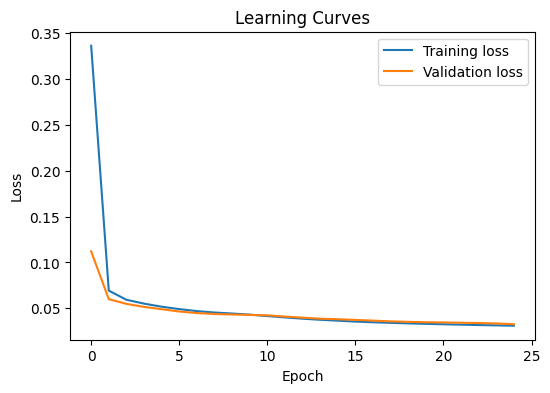

Test AUC: 0.9991

Test Accuracy: 0.9842

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     46838
         1.0       0.99      0.92      0.95      9412

    accuracy                           0.98     56250
   macro avg       0.99      0.96      0.97     56250
weighted avg       0.98      0.98      0.98     56250

Confusion Matrix:
[[46747    91]
 [  797  8615]]

Report: {'accuracy': 0.9842133333333334, 'f1_score_positive': 0.9509879677668617, 'auc': 0.9990828153470979, 'true_positives': np.int64(8615), 'false_positives': np.int64(91), 'true_negatives': np.int64(46747), 'false_negatives': np.int64(797)}


In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Generate boolean labels on a grid (fast)
X2d, Y2d, in_set = mandelbrot_grid_dataset(nx=750, ny=750, max_iter=1000)

# Flatten to (N, 2) and (N,)
X = np.stack([X2d.ravel(), Y2d.ravel()], axis=-1).astype(np.float32)
y = in_set.ravel().astype(np.float32)

# Stratified split
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42, shuffle=True
)

# Model
model = NeuralNet(num_hidden_layers=4)

# Train
model = train(
    model, X_train, y_train, X_val, y_val,
    num_epoch=25, batch_size=2048, lr=1e-3,
    visualize=True
)

# Test
report = test(model, X_test, y_test, threshold=0.5)
print("\nReport:", report)